# Elastic Net Regression 

In [1]:
import pandas as pd 
import numpy as np 

## Setting Up the Data 

In [2]:
df = pd.read_csv('modeling_data.csv')
print(df.shape)
df.head()

(687, 17)


,TEAM_SEASON,LS_MIN,LS_EFG_PCT,LS_FTA_RATE,LS_TM_TOV_PCT,LS_OREB_PCT,LS_OPP_EFG_PCT,LS_OPP_FTA_RATE,LS_OPP_TOV_PCT,LS_OPP_OREB_PCT,HEIGHT_INCHES,WEIGHT,EXP,LS_WIN_PCT,PO_WINS,TEAM_ID,TEAM_NAME
0,1610612737_2001-02,18.097566,0.461098,0.324734,0.163691,0.266759,0.476202,0.355158,0.153661,0.286407,80.000000,224.615385,3.153846,0.305,0.0,1610612737,Hawks
1,1610612737_2002-03,17.691622,0.459190,0.296291,0.165052,0.252703,0.490334,0.332949,0.151786,0.301969,79.187500,224.562500,4.125000,0.402,0.0,1610612737,Hawks
2,1610612737_2003-04,16.653165,0.467314,0.320842,0.167814,0.275845,0.480911,0.323210,0.142232,0.289654,80.133333,227.000000,4.000000,0.427,0.0,1610612737,Hawks
3,1610612737_2004-05,13.812289,0.432378,0.324171,0.166552,0.250593,0.494104,0.375538,0.167617,0.286726,79.769231,225.923077,5.076923,0.341,0.0,1610612737,Hawks
4,1610612737_2005-06,21.489895,0.463531,0.327702,0.170385,0.274347,0.510406,0.369320,0.144927,0.280918,78.846154,223.615385,1.923077,0.159,0.0,1610612737,Hawks


In [3]:
def modeling_data_setup(data,test_seasons,this_season,model_type):
    # returns x, xtest, y, ytest, this season's data 
    
    target = 'PO_WINS'
    
    import pandas as pd
    import numpy as np 
    
    if type(test_seasons) == int:
        test_seasons = [test_seasons]
    elif type(test_seasons) == list:
        test_seasons = test_seasons
    else:
        raise TypeError("ERROR! Please enter the test_seasons as type int or list (of int)")
        
    for i in test_seasons:
        if type(i)!=int:
            raise TypeError("ERROR! Please enter the test_seasons as type int or list (of int)")
    
    import pandas as pd
    import numpy as np 
    from sklearn.model_selection import train_test_split
    
    print('columns to drop:')
    drop_cols = ['TEAM_SEASON','TEAM_ID','TEAM_NAME','PO_WINS','SEASON']
    print(drop_cols)
    
    print('Creating SEASON for splitting')
    ids = data['TEAM_SEASON'].str.split('_')
    season = [int(x[1][0:4]) for x in ids]
    data['SEASON'] = season
    
    print("Dropping this season: {}".format(this_season))
    current = data[data['SEASON']==this_season].copy()
    
    print('Dropping the Pelicans and Hornets first season')
    data = data[~data['LS_WIN_PCT'].isna()].copy()
    
    test = data[data['SEASON'].isin(test_seasons)].copy()
    train = data[(~data['SEASON'].isin(test_seasons))&(data['SEASON']!=this_season)].copy()
    ytest = test[target].copy()
    ytrain = train[target].copy()
    xtest = test.drop(drop_cols,axis=1)
    xtrain = train.drop(drop_cols,axis=1)
    
    print("Returning: Train, Test, X Train, X Test, Y Train, Y Test, and the Upcoming Season")
    
    return train,test,xtrain,xtest,ytrain,ytest,current

In [4]:
train, test, x_train, x_test, y_train, y_test, upcoming = modeling_data_setup(df,[2022],2023,'reg')

columns to drop:
['TEAM_SEASON', 'TEAM_ID', 'TEAM_NAME', 'PO_WINS', 'SEASON']
Creating SEASON for splitting
Dropping this season: 2023
Dropping the Pelicans and Hornets first season
Returning: Train, Test, X Train, X Test, Y Train, Y Test, and the Upcoming Season


In [5]:
id_cols = ['TEAM_SEASON','TEAM_ID','TEAM_NAME','SEASON']
train_ids = train[id_cols].copy()
test_ids = test[id_cols].copy()

## Modeling

In [6]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for feature reduction 
from sklearn import feature_selection
from sklearn import pipeline

# for the modeling
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import sklearn

# getting rid of the warnings 
import warnings
warnings.filterwarnings('ignore')

In [15]:
param_grid = {
                'alpha'     : np.arange(0.001,10.00,0.1),
                'l1_ratio'  :  np.arange(0.001,1.00,0.01),
                'tol'       : [0.0001,0.001],
                'fit_intercept': [True,False]
            }
eNet = ElasticNet(max_iter=10000)
clf = GridSearchCV(eNet, 
                           param_grid, 
                           scoring='neg_root_mean_squared_error', 
                           cv = 5,
                           return_train_score=True,
                           verbose = 10, 
                           n_jobs = -1
                  )

In [16]:
# Fitting the model 
clf.fit(x_train,y_train)

print("Tuned Hyperparameters :", clf.best_params_)
print("Best Score :",clf.best_score_)

Fitting 5 folds for each of 40000 candidates, totalling 200000 fits
Tuned Hyperparameters : {'alpha': 0.001, 'fit_intercept': False, 'l1_ratio': 0.001, 'tol': 0.0001}
Best Score : -3.6900314621514703


In [17]:
# storing the CV results 
cv = pd.DataFrame(clf.cv_results_)

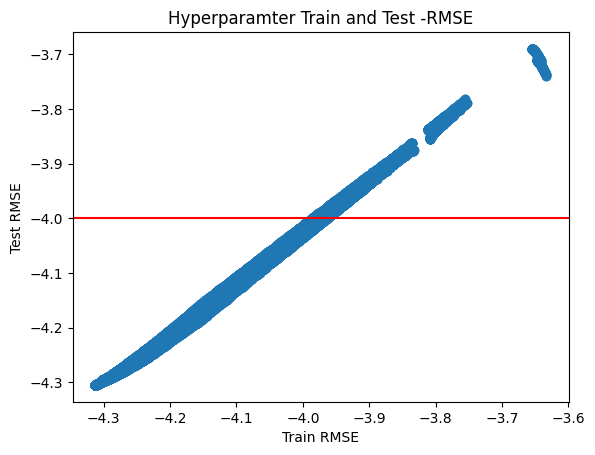

In [18]:
#Plotting the test and train gini to select best parameter
import matplotlib.pyplot as plt
plt.scatter(cv['mean_train_score'],cv['mean_test_score'] )
plt.axhline(0.-4, color='r', linestyle='-')
plt.xlabel('Train RMSE')
plt.ylabel('Test RMSE')
#for i in range(cv.shape[0]):
#    plt.text(x=cv['mean_train_score'][i],y=cv['mean_test_score'][i]+0.03,s=cv['rank_test_score'][i],fontdict=dict(size=5))
plt.title('Hyperparamter Train and Test -RMSE')
plt.show()

In [19]:
cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_l1_ratio,param_tol,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002557,0.000112,0.001380,0.000022,0.001,True,0.001,0.0001,"{'alpha': 0.001, 'fit_intercept': True, 'l1_ra...",-3.983090,...,-3.710146,0.593438,195,-3.591057,-3.400241,-3.781370,-3.666960,-3.800495,-3.648025,0.145622
1,0.002429,0.000116,0.001368,0.000029,0.001,True,0.001,0.001,"{'alpha': 0.001, 'fit_intercept': True, 'l1_ra...",-3.983090,...,-3.710147,0.593438,196,-3.591057,-3.400241,-3.781370,-3.666960,-3.800495,-3.648025,0.145622
2,0.002360,0.000063,0.001342,0.000036,0.001,True,0.011,0.0001,"{'alpha': 0.001, 'fit_intercept': True, 'l1_ra...",-3.983139,...,-3.710186,0.593395,197,-3.591008,-3.400206,-3.781297,-3.666890,-3.800408,-3.647962,0.145604
3,0.002431,0.000179,0.001451,0.000127,0.001,True,0.011,0.001,"{'alpha': 0.001, 'fit_intercept': True, 'l1_ra...",-3.983139,...,-3.710186,0.593395,198,-3.591008,-3.400206,-3.781297,-3.666890,-3.800408,-3.647962,0.145604
4,0.002370,0.000051,0.001313,0.000016,0.001,True,0.021,0.0001,"{'alpha': 0.001, 'fit_intercept': True, 'l1_ra...",-3.983188,...,-3.710227,0.593351,199,-3.590960,-3.400171,-3.781224,-3.666819,-3.800319,-3.647898,0.145586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.002019,0.000054,0.001331,0.000041,9.901,False,0.971,0.001,"{'alpha': 9.901, 'fit_intercept': False, 'l1_r...",-4.448859,...,-4.294975,0.729113,26465,-4.280518,-3.953041,-4.480091,-4.319794,-4.479354,-4.302560,0.192728
39996,0.001992,0.000033,0.001415,0.000078,9.901,False,0.981,0.0001,"{'alpha': 9.901, 'fit_intercept': False, 'l1_r...",-4.448923,...,-4.294963,0.729212,26455,-4.280523,-3.953046,-4.480095,-4.319798,-4.479358,-4.302564,0.192727
39997,0.002014,0.000038,0.001341,0.000050,9.901,False,0.981,0.001,"{'alpha': 9.901, 'fit_intercept': False, 'l1_r...",-4.448923,...,-4.294963,0.729212,26455,-4.280523,-3.953046,-4.480095,-4.319798,-4.479358,-4.302564,0.192727
39998,0.001999,0.000047,0.001364,0.000043,9.901,False,0.991,0.0001,"{'alpha': 9.901, 'fit_intercept': False, 'l1_r...",-4.448986,...,-4.294951,0.729311,26453,-4.280527,-3.953051,-4.480100,-4.319803,-4.479362,-4.302569,0.192727


In [20]:
clf.best_estimator_.get_params()

{'alpha': 0.001,
 'copy_X': True,
 'fit_intercept': False,
 'l1_ratio': 0.001,
 'max_iter': 10000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [21]:
cv[cv['mean_test_score']==max(cv['mean_test_score'])]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_l1_ratio,param_tol,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
200,0.047177,0.001269,0.001354,0.000081,0.001,False,0.001,0.0001,"{'alpha': 0.001, 'fit_intercept': False, 'l1_r...",-3.927704,...,-3.690031,0.579987,1,-3.60614,-3.402029,-3.787539,-3.673638,-3.806631,-3.655195,0.146484
201,0.053708,0.004433,0.001287,0.000067,0.001,False,0.001,0.001,"{'alpha': 0.001, 'fit_intercept': False, 'l1_r...",-3.927704,...,-3.690031,0.579987,1,-3.60614,-3.402029,-3.787539,-3.673638,-3.806631,-3.655195,0.146484


## Evaluation

### Train 

In [22]:
predictions = clf.predict(x_train)

In [23]:
mse = sklearn.metrics.mean_squared_error(y_train,predictions)
mae = sklearn.metrics.mean_absolute_error(y_train,predictions)
r2 = sklearn.metrics.r2_score(y_train,predictions)
rmse = np.sqrt(mse)

In [24]:
train_output = pd.DataFrame({'Actual':y_train,'Prediction':predictions})
train_output['Team'] = train['TEAM_NAME']
train_output['Season'] = train['SEASON']
train_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
train_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
train_results = train_results.transpose().reset_index(drop=True)
train_results.columns = train_results.iloc[0,:]
train_results = train_results.tail(1)

In [25]:
train_output.tail()

,Actual,Prediction,Team,Season
295,7.0,5.432690,Bucks,2021
456,7.0,5.685970,Suns,2021
594,2.0,6.116878,Jazz,2021
249,0.0,6.503709,Lakers,2021
341,0.0,6.770792,Nets,2021


In [26]:
train_results

,MSE,MAE,R2,RMSE
1,13.446154,2.690658,0.280073,3.6669


### Test 

In [27]:
predictions = clf.predict(x_test)

In [28]:
mse = sklearn.metrics.mean_squared_error(y_test,predictions)
mae = sklearn.metrics.mean_absolute_error(y_test,predictions)
r2 = sklearn.metrics.r2_score(y_test,predictions)
rmse = np.sqrt(mse)

In [29]:
test_output = pd.DataFrame({'Actual':y_test,'Prediction':predictions})
test_output['Team'] = test['TEAM_NAME']
test_output['Season'] = test['SEASON']
test_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
test_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
test_results = test_results.transpose().reset_index(drop=True)
test_results.columns = test_results.iloc[0,:]
test_results = test_results.tail(1)

In [30]:
test_output.head()

,Actual,Prediction,Team,Season
549,0.0,-2.445763,Thunder,2022
204,0.0,-0.879594,Rockets,2022
388,0.0,-0.407075,Magic,2022
664,0.0,-0.148494,Pistons,2022
480,0.0,-0.112214,Trail Blazers,2022


In [31]:
test_results

,MSE,MAE,R2,RMSE
1,12.900768,2.639803,0.299886,3.591764


### Upcoming Season 

In [32]:
x_up = upcoming[clf.best_estimator_.feature_names_in_]
x_up.head()

,LS_MIN,LS_EFG_PCT,LS_FTA_RATE,LS_TM_TOV_PCT,LS_OREB_PCT,LS_OPP_EFG_PCT,LS_OPP_FTA_RATE,LS_OPP_TOV_PCT,LS_OPP_OREB_PCT,HEIGHT_INCHES,WEIGHT,EXP,LS_WIN_PCT
22,18.016026,0.545016,0.266234,0.138654,0.244933,0.546807,0.273492,0.132161,0.228750,74.210526,212.500000,4.210526,0.500
45,17.141471,0.574906,0.245406,0.154088,0.205274,0.551555,0.261706,0.134655,0.210411,79.235294,221.470588,5.352941,0.695
68,18.456579,0.533045,0.246079,0.154702,0.218635,0.528808,0.282211,0.151173,0.226084,77.894737,211.263158,5.000000,0.622
90,19.033183,0.531229,0.300521,0.136806,0.241501,0.540870,0.260355,0.134875,0.219382,78.500000,215.875000,4.375000,0.512
113,20.332340,0.553620,0.264355,0.128804,0.215955,0.533605,0.257386,0.150217,0.204654,78.000000,214.150000,4.650000,0.488


In [33]:
predictions = clf.predict(x_up)
final_output = x_up.copy() 
final_output['Predicted Wins'] = predictions
final_output['Predicted Wins (Rounded)'] = [round(x) for x in predictions]
final_output['Team'] = upcoming['TEAM_NAME']
def rounds(x):
    if x < 4:
        return 'R1/Lottery'
    elif 4<=x<8:
        return 'Second Round'
    elif 8<=x<12: 
        return 'Conf. Finals'
    elif 12<=x<16:
        return 'Finals'
    elif x>=16:
        return 'Champions'
final_output['Round'] = [rounds(x) for x in final_output['Predicted Wins']]
final_output.sort_values('Predicted Wins',inplace=True)
fo = final_output[['Team','Predicted Wins','Predicted Wins (Rounded)','Round']]
fo

,Team,Predicted Wins,Predicted Wins (Rounded),Round
686,Hornets,-1.182434,-1,R1/Lottery
527,Spurs,-0.801945,-1,R1/Lottery
665,Pistons,-0.792910,-1,R1/Lottery
205,Rockets,-0.773069,-1,R1/Lottery
550,Thunder,-0.140469,0,R1/Lottery
481,Trail Blazers,0.375379,0,R1/Lottery
412,Pacers,0.775700,1,R1/Lottery
642,Wizards,0.865362,1,R1/Lottery
389,Magic,1.309664,1,R1/Lottery
596,Jazz,1.747572,2,R1/Lottery


In [34]:
len(list(final_output['Team']))

30

In [35]:
ec_teams = ['Hornets',
 'Wizards',
 'Hawks',
 'Pacers',
 'Magic',
 'Pistons',
 'Raptors',
 'Knicks',
 'Bulls',
 'Cavaliers',
 'Nets',
 '76ers',
 'Heat',
 'Celtics',
 'Bucks']
wc_teams = ['Thunder',
 'Rockets',
 'Spurs',
 'Trail Blazers',
 'Kings',
 'Pelicans',
 'Grizzlies',
 'Timberwolves',
 'Jazz',
 'Warriors',
 'Mavericks',
 'Lakers',
 'Clippers',
 'Suns',
 'Nuggets']

In [36]:
ec = fo[fo['Team'].isin(ec_teams)]
wc = fo[fo['Team'].isin(wc_teams)]

In [37]:
print("Bet to Win EC: ")
ecb = ec.sort_values('Predicted Wins').tail(4)
ecb

Bet to Win EC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
274,Heat,3.993668,4,R1/Lottery
435,76ers,4.737421,5,Second Round
45,Celtics,5.307493,5,Second Round
297,Bucks,6.389334,6,Second Round


In [38]:
print("Bet to Win WC: ")
wcb = wc.sort_values('Predicted Wins').tail(4)
wcb

Bet to Win WC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
228,Clippers,3.864405,4,R1/Lottery
458,Suns,5.033035,5,Second Round
182,Warriors,5.422975,5,Second Round
159,Nuggets,6.150758,6,Second Round


In [39]:
print("Bet to Win NBA Finals: ")
fob = fo.sort_values('Predicted Wins').tail(4)
fob

Bet to Win NBA Finals: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
45,Celtics,5.307493,5,Second Round
182,Warriors,5.422975,5,Second Round
159,Nuggets,6.150758,6,Second Round
297,Bucks,6.389334,6,Second Round


## Writing Info 

In [40]:
train_output['SUBSET'] = 'TRAIN'
test_output['SUBSET'] = 'TEST'
total_output = pd.concat([train_output,test_output])

In [41]:
train_results['SUBSET'] = 'TRAIN'
test_results['SUBSET'] = 'TEST'
total_results = pd.concat([train_results,test_results])
total_results

,MSE,MAE,R2,RMSE,SUBSET
1,13.446154,2.690658,0.280073,3.6669,TRAIN
1,12.900768,2.639803,0.299886,3.591764,TEST


In [42]:
model_name = input()

en_20231008


In [43]:
initial_path = ''
cv_path = initial_path+model_name+'_cv_results.csv'
output_path = initial_path+model_name+'_output.csv'
results_path = initial_path+model_name+'_results.csv'
predictions_path = initial_path+model_name+'_full_predictions.csv'
ec_path = initial_path+model_name+'_ecf_predictions.csv'
wc_path = initial_path+model_name+'_wcf_predictions.csv'
f_path = initial_path+model_name+'_finals_predictions.csv'
print(cv_path)
print(output_path)
print(results_path)
print(predictions_path)
print(ec_path)
print(wc_path)
print(f_path)

en_20231008_cv_results.csv
en_20231008_output.csv
en_20231008_results.csv
en_20231008_full_predictions.csv
en_20231008_ecf_predictions.csv
en_20231008_wcf_predictions.csv
en_20231008_finals_predictions.csv


In [45]:
cv.to_csv(cv_path,index=False)
total_output.to_csv(output_path,index=False)
total_results.to_csv(results_path,index=False)
fo.to_csv(predictions_path,index=False)
ecb.to_csv(ec_path,index=False)
wcb.to_csv(wc_path,index=False)
fob.to_csv(f_path,index=False)

In [46]:
import pickle

# save the model to disk
filename = model_name+'.sav'
pickle.dump(clf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

## What if I had Used this Model Last Year? 

In [47]:
ec2 = test_output[test_output['Team'].isin(ec_teams)]
wc2 = test_output[test_output['Team'].isin(wc_teams)]

In [48]:
print("Bet to Win EC: ")
ecb2 = ec2.sort_values('Prediction').tail(4)
ecb2

Bet to Win EC: 


,Actual,Prediction,Team,Season,SUBSET
434,7.0,4.901309,76ers,2022,TEST
44,11.0,5.431766,Celtics,2022,TEST
273,13.0,5.727737,Heat,2022,TEST
296,1.0,6.296099,Bucks,2022,TEST


In [49]:
print("Bet to Win WC: ")
wcb2 = wc2.sort_values('Prediction').tail(4)
wcb2

Bet to Win WC: 


,Actual,Prediction,Team,Season,SUBSET
181,6.0,4.493060,Warriors,2022,TEST
135,0.0,4.711875,Mavericks,2022,TEST
158,16.0,5.529164,Nuggets,2022,TEST
457,6.0,6.823553,Suns,2022,TEST


In [50]:
print("Bet to Win NBA Finals: ")
fob2 = test_output.sort_values('Prediction').tail(4)
fob2

Bet to Win NBA Finals: 


,Actual,Prediction,Team,Season,SUBSET
158,16.0,5.529164,Nuggets,2022,TEST
273,13.0,5.727737,Heat,2022,TEST
296,1.0,6.296099,Bucks,2022,TEST
457,6.0,6.823553,Suns,2022,TEST
